In [1]:
import sys
import os

# Add the workspace directory to the system path
sys.path.append(os.path.abspath('..'))

# Now you should be able to import the class
from model import preprocess_data
from model.train import HST

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2024-07-18 09:08:15.442081: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 09:08:15.809346: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-18 09:08:15.811755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-18 09:08:17.016338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
%matplotlib inline

In [2]:
train_dataset, test_dataset = preprocess_data.load_data(data_path="/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/df_jrdb.pkl", batch_size=32)

2024-07-18 09:08:24.078803: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-18 09:08:45.217545: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled
2024-07-18 09:08:54.076469: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-18 09:09:24.076990: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-18 09:09:54.080279: W tensorflow/core/framework/dataset.cc:956] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-18 09:10:24

In [8]:
import datetime
import tensorflow as tf

model_base_dir = ""
dt_str = datetime.datetime.now().strftime('2024-07-15_15:57:20')
model_dir = os.path.join(model_base_dir, dt_str)
ckpt_dir = "/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/first_train/ckpts/last"
ckpt_best_dir = "/home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/first_train/ckpts_best/ckpt"

def test_model(checkpoint_dir, test_dataset):
    
    model = HST(15)  # Initialize the model architecture
    optimizer = tf.keras.optimizers.Adam()
    
    # Create a checkpoint object
    checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
    
    # Restore the latest checkpoint
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        checkpoint.restore(latest_checkpoint)
        print(f"Restored checkpoint from {latest_checkpoint}")
    else:
        print("No checkpoint found.")
        return
    
    # Run a forward pass with a batch from the test dataset
    for (batch_x1, batch_x2) in test_dataset.take(1):
        input_batch = (batch_x1, batch_x2)
        output = model(input_batch, training=False)
        #print(output)
        break
    return input_batch, output


In [9]:
input, pred = test_model(ckpt_dir, test_dataset)

Restored checkpoint from /home/pbr-student/personal/thesis/test/PedestrianTrajectoryPrediction/first_train/ckpts/last/ckpt-22


/tmp/ipykernel_4678/2795469976.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


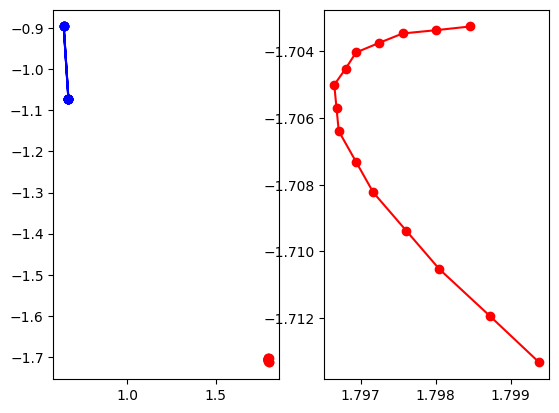

In [27]:
import matplotlib.pyplot as plt 
import numpy as np 

idx = 6
mode = 0

ground_truth = input[0][idx][:,:2].numpy()
prediction = pred["position"][idx,:,mode,:2].numpy()


fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(ground_truth[:,0], ground_truth[:,1], 'ro-')
ax1.plot(prediction[:,0], prediction[:,1],'bo-')
ax2.plot(ground_truth[:,0], ground_truth[:,1], 'ro-')
fig.show()

# Plot training loss

In [13]:
import pandas as pd

train_loss_dir = "/home/pbr-student/Downloads/train.csv"
eval_loss_dir = "/home/pbr-student/Downloads/eval.csv"

train_loss = pd.read_csv(train_loss_dir)
eval_loss = pd.read_csv(eval_loss_dir)

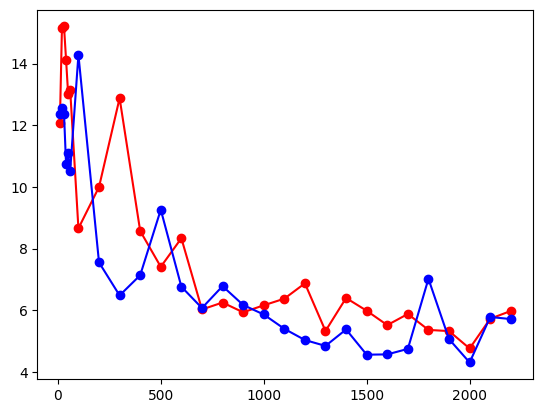

In [16]:
plt.plot(train_loss["Step"], train_loss["Value"], 'ro-')
plt.plot(eval_loss["Step"], eval_loss["Value"], 'bo-')
plt.show()